In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#Market and option parameters as in section 4.1 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
s_0 = 100
r = 0.01
mu = 0.05
sigma = 0.2
tau = 1/52
T = 1/3
K = 100

In [3]:
#sizes of the training and validation sets
M_1 = 250000
M_2 = 500000

In [4]:
#generate simulations of standard normal random variables
Z = np.random.normal(loc=0, scale=1, size=M_1+M_2)
V = np.random.normal(loc=0, scale=1, size=M_1+M_2)

#simulate S_tau under P
S_tau = s_0 * np.exp( (mu-0.5*sigma**2)*tau + sigma*np.sqrt(tau)*Z)
#siumulate S_T under Q
S_T = S_tau * np.exp( (r-0.5*sigma**2)*(T-tau) + sigma*np.sqrt(T-tau)*V)
#compute discounted payoff of put option at time tau
P_T = np.exp(-r*(T-tau)) * np.maximum(K-S_T,0)

In [5]:
#perform a grid search algorithm for hyperparameter tuning
min_samples_leaf_list = [50,100,250,500,750,1250,1500,1750,2000,2500,3500,4000,4500,5000]
score_list = []

opt_param = 0
opt_score = np.inf

for min_samples_leaf in min_samples_leaf_list:
    rfr = RandomForestRegressor(n_estimators=160, min_samples_leaf=min_samples_leaf, bootstrap=True, criterion='mse', verbose=0, n_jobs=-1)
    rfr.fit(X=S_tau[0:M_1].reshape(-1,1), y=P_T[0:M_1])
    score = mean_squared_error(y_true=P_T[M_1:M_1+M_2], y_pred=rfr.predict(S_tau[M_1:M_1+M_2].reshape(-1,1)))
    score_list.append(score)
    print('min_samples_leaf: ', min_samples_leaf, ', MSE: ', score)
    if score < opt_score:
        opt_param = min_samples_leaf
        opt_score = score
        print('New best!')

print('Best parameters found in grid search: ', opt_param, ' with MSE ', opt_score)

min_samples_leaf:  50 , MSE:  36.972754954600596
New best!
min_samples_leaf:  100 , MSE:  36.64615718216356
New best!
min_samples_leaf:  250 , MSE:  36.44768015773882
New best!
min_samples_leaf:  500 , MSE:  36.38605603257024
New best!
min_samples_leaf:  750 , MSE:  36.362107636512455
New best!
min_samples_leaf:  1250 , MSE:  36.34381569257209
New best!
min_samples_leaf:  1500 , MSE:  36.338026712374905
New best!
min_samples_leaf:  1750 , MSE:  36.33332952471897
New best!
min_samples_leaf:  2000 , MSE:  36.32876184347717
New best!
min_samples_leaf:  2500 , MSE:  36.32394659371116
New best!
min_samples_leaf:  3500 , MSE:  36.32199734513789
New best!
min_samples_leaf:  4000 , MSE:  36.32254641599379
min_samples_leaf:  4500 , MSE:  36.32200789380808
min_samples_leaf:  5000 , MSE:  36.32209894378779
Best parameters found in grid search:  3500  with MSE  36.32199734513789


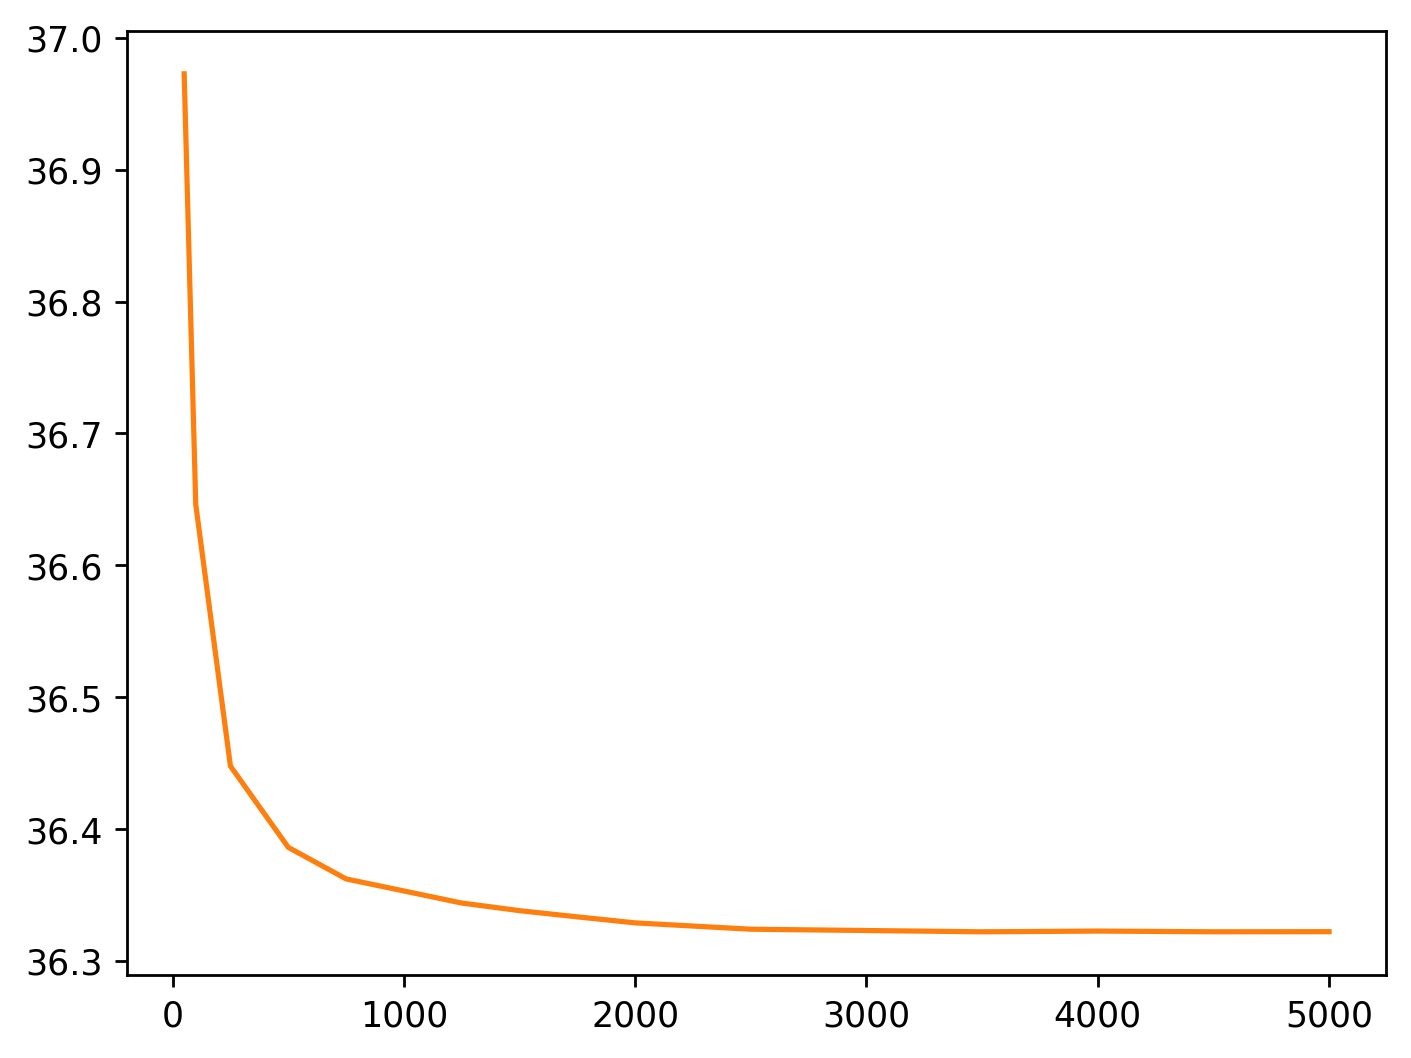

In [6]:
#plot of validation MSE against min_samples_leaf
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(min_samples_leaf_list, score_list, color='tab:orange')
plt.show()

In [7]:
#train a random forest with hyperparameters found in the grid search
rfr = RandomForestRegressor(n_estimators=160, min_samples_leaf=int(opt_param), bootstrap=True, criterion='mse', verbose=0, n_jobs=-1)
rfr.fit(X=S_tau[0:M_1].reshape(-1,1), y=P_T[0:M_1])

RandomForestRegressor(min_samples_leaf=3500, n_estimators=160, n_jobs=-1)

The following is the reason that the calculation of an IS density fails, see Put_VaR_ES_IS_250_failed_IS_RF.ipynb

In [11]:
L_hat = rfr.predict(S_tau[0:M_1].reshape(-1,1))
L_hat_sort = L_hat[L_hat.argsort()[::-1]]
VaR_hat_alpha = L_hat_sort[int(M_1*(1-0.995))]

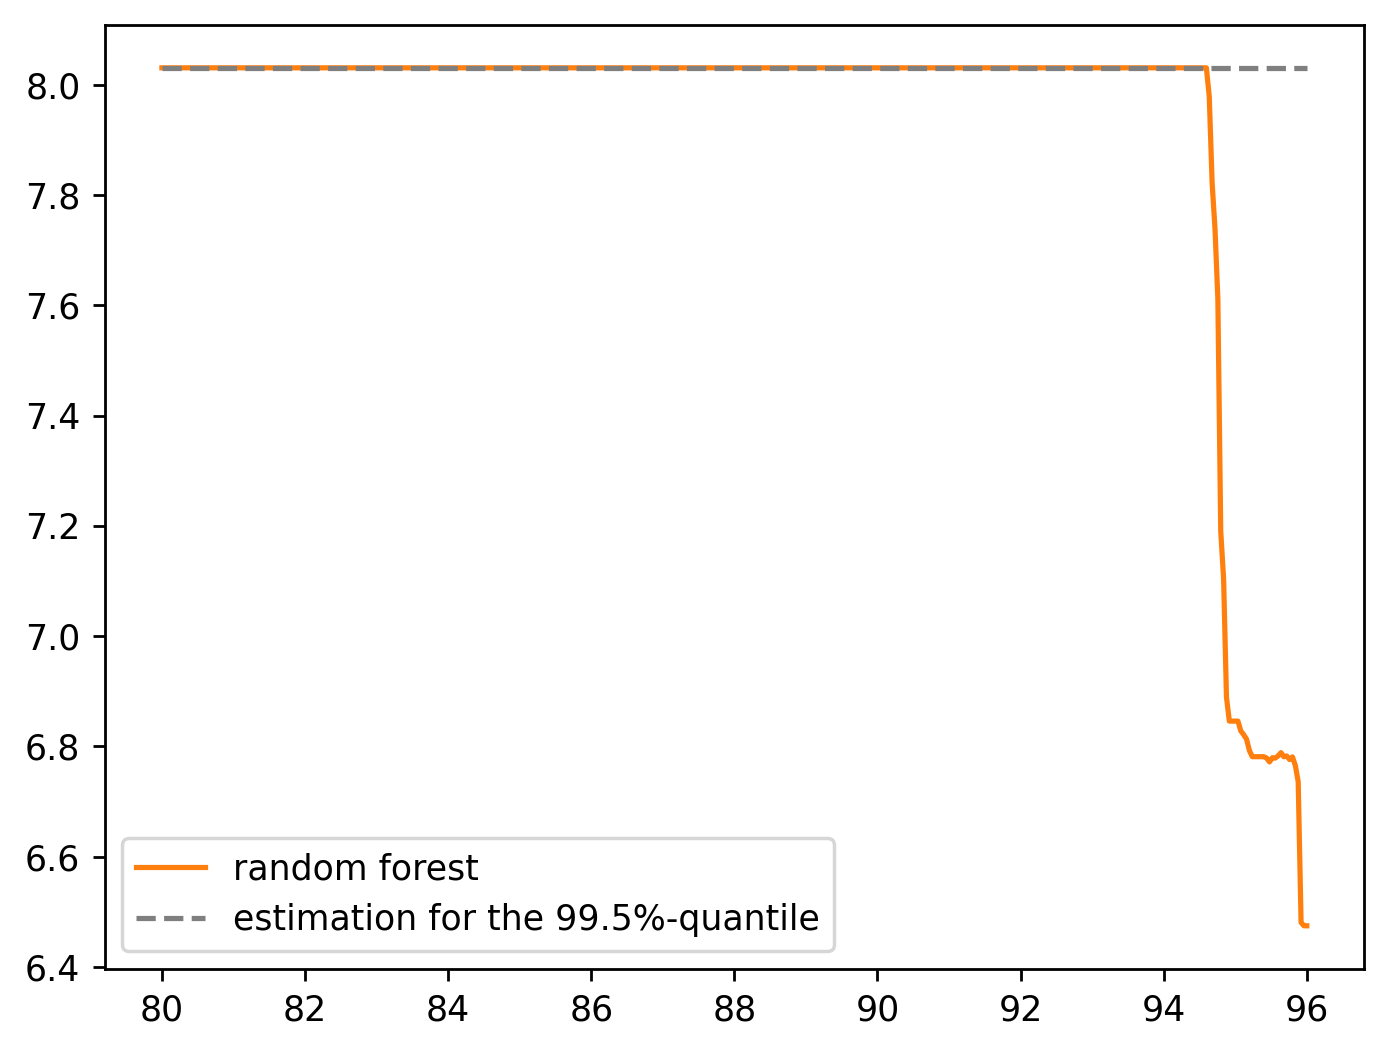

In [15]:
x = np.linspace(80, 96, 400)

plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(x, rfr.predict(x.reshape((-1,1))), color='tab:orange')
plt.plot(x, np.full(len(x),VaR_hat_alpha), color='tab:grey', linestyle='--')
plt.legend(['random forest','estimation for the 99.5%-quantile'])
plt.show()